In [1]:
#Code written by Keisuke Yano 11/30/2024
#Import libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import linalg
import pandas as pd
import random
import matplotlib.gridspec as gridspec
import scipy.optimize as opt
from scipy.optimize import Bounds
from scipy.fft import fft, ifft, fftfreq


import matplotlib
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'
matplotlib.rcParams['lines.linewidth'] = 2
import matplotlib as mpl
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.ymargin'] = 0

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
#spectral models
def spd_Brune(omega,theta):
  sig     = theta[0]
  omega_c = theta[1]
  alpha   = theta[2]
  spd     = (sig**2)* ( 1 + (abs(omega)/omega_c)**alpha)**(-2)
  return spd

def spd_Brune_omegafix(omega,theta):
  sig     = theta[0]
  omega_c = 0.5
  alpha   = theta[1]
  spd     = (sig**2)* ( 1 + (abs(omega)/omega_c)**alpha)**(-2)
  return spd

def spd_Matern(omega,theta):
  sig     = theta[0]
  omega_c = theta[1]
  alpha   = theta[2]
  spd     = (sig**2)* ( 1 + (abs(omega)/omega_c)**2)**(-alpha)
  return spd

def spd_AR1(x, theta):
    sig = theta[0]
    rho = 2*(1/(1+np.exp(-theta[1]))-1/2)

    spd = (sig**2 / (2 * np.pi)) * (1 - 2 * rho * np.cos(x) + rho**2)**(-1)

    return spd

In [3]:
#Periodgram and AR simulation
def periodgram(data,samplingfreq=1.):
  #list of Periodgram at samplingfreq * i/N
  N  = len(data)
  F = [2*np.pi*(i/N) for i in range(N)][1:int(N/2)]
  Omega = fftfreq(N, samplingfreq)[1:int(N/2)]
  In = (2*np.pi*N)**(-1) * (abs(fft(data))[1:int(N/2)]**2)
  return Omega,F,In

def sim_AR1(N, theta):
    sig = theta[0]
    rho = 2*(1/(1+np.exp(-theta[1]))-1/2)
    AR = np.zeros(N + 1)
    AR[0] = np.random.normal()  # Initial value
    WN = np.random.normal(size=N)
    for t in range(1, N + 1):
        AR[t] = rho * AR[t - 1] + sig * WN[t - 1]
    return AR[1:]

In [4]:
#Gradient descents for AR models under spectral Renyi divergence minimization and Itakura--Saito divergence minimization

def derivative_logspec_AR1(omega,theta):
  sig = theta[0]
  rho = 2*(1/(1+np.exp(-theta[1]))-1/2)
  ret1=2
  ret2=(1+rho)*(1-rho)*(np.cos(omega)-rho)/(1-2*rho*np.cos(omega)+rho**2)
  return np.array([ret1,ret2])

def gradient_specRenyi_AR1(Freq,In,S,theta,alpha):
  n = len(In)
  mid1 = np.array([(1 - S(Freq[i],theta)/(alpha*S(Freq[i],theta)+(1-alpha)*In[i]))*derivative_logspec_AR1(Freq[i],theta)
   for i in range(0,n)])
  return (alpha/(1-alpha))*mid1.mean(axis=0)

def gradient_IS_AR1(Freq,In,S,theta):
  n = len(In)
  mid1 = np.array([(In[i]/S(Freq[i],theta)-1)*derivative_logspec_AR1(Freq[i],theta)
   for i in range(0,n)])
  return mid1.mean(axis=0)

In [5]:
#Optimization using solvers
def spectralRenyi(Freq,In,S,theta,alpha):
  n = len(In)
  ret = np.array([np.log(alpha*In[i]+(1-alpha)*S(Freq[i],theta))-alpha*np.log(In[i])-(1-alpha)*np.log(S(Freq[i],theta)) for i in range(0,n)])
  return sum(ret)/(alpha*(1-alpha)*n)

def ItakuraSaito(Freq,In,S,theta):
  n = len(In)
  ret = np.array([In[i]/S(Freq[i],theta)-1+np.log(S(Freq[i],theta))-np.log(In[i]) for i in range(0,n)])
  return sum(ret)/n


def spectralRenyiestimation(Freq,In,S,init,alpha,bounds,method):
  def D(theta):
    return spectralRenyi(Freq=Freq,In=In,S=S,theta=theta,alpha=alpha)
  trajectory = []
  def callback(xk):
    trajectory.append(xk.copy())
  A=opt.minimize(fun=D, x0=init, jac=None,method=method,hess=None, hessp=None, bounds=bounds, constraints=(), tol=10**(-5), options=None,callback=callback)
  return A.x,trajectory

def ItakuraSaitoestimation(Freq,In,S,init,bounds,method):
  def D(theta):
    return ItakuraSaito(Freq=Freq,In=In,S=S,theta=theta)
  trajectory = []
  def callback(xk):
    trajectory.append(xk.copy())
  A=opt.minimize(fun=D, x0=init, jac=None,method=method,hess=None, hessp=None,
                 bounds=bounds, constraints=(), tol=10**(-5), options=None,callback=callback)
  return A.x,trajectory

# Test using gradient descent method

In [43]:
true= np.array([1,0.0])
init= np.array([2,2.0])
n=1000
m=5000
step_size = 0.01

result_Renyi = []
result_IS = []
for z_root in [0,10,100]:
  ysim= sim_AR1(N=n,theta=true) + z_root*np.array([np.sin(k*np.pi/2) for k in range(n)])
  In=periodgram(ysim)[2]
  Freq = periodgram(ysim)[1]
  traj_Renyi = [init]
  traj_IS = [init]
  for t in range(1,m):
    traj_Renyi.append(traj_Renyi[t-1]+step_size*gradient_specRenyi_AR1(Freq,In,spd_AR1,traj_Renyi[t-1],0.5))
    traj_IS.append(traj_IS[t-1]+step_size*gradient_IS_AR1(Freq,In,spd_AR1,traj_IS[t-1]))
  result_Renyi.append(traj_Renyi)
  result_IS.append(traj_IS)
  print(z_root)

0
10
100


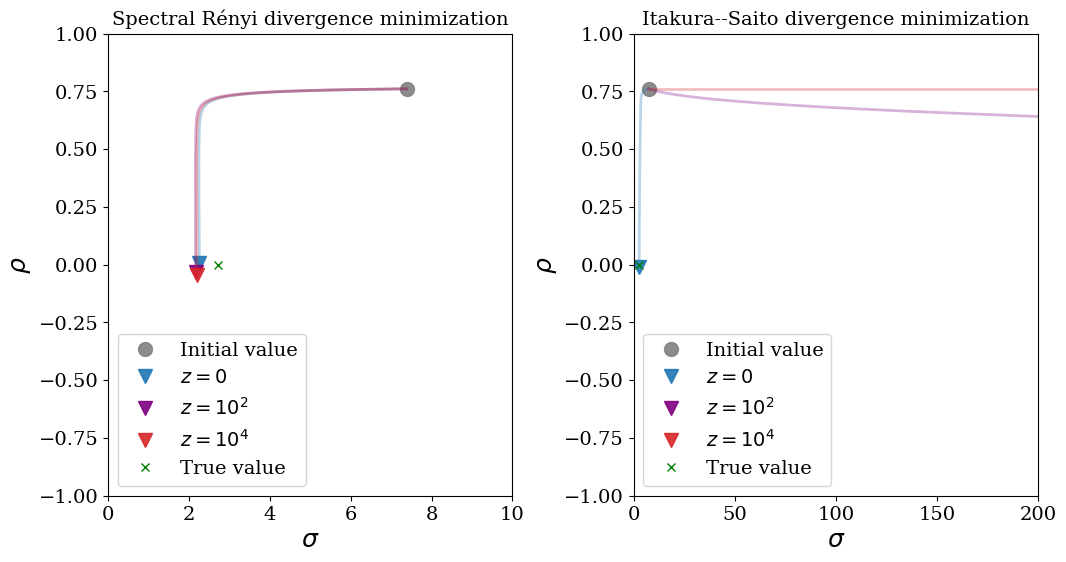

In [44]:
fontsize = 18
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0.3)

ax1.set_xlabel(r"$\sigma$",fontsize=fontsize)
ax1.set_ylabel(r"$\rho$",fontsize=fontsize)
ax2.set_xlabel(r"$\sigma$",fontsize=fontsize)
ax2.set_ylabel(r"$\rho$",fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax1.set_xlim(0,10)
ax1.set_ylim(-1,1)
ax2.set_xlim(0,200)
ax2.set_ylim(-1,1)
ax1.set_title("Spectral Rényi divergence minimization",fontsize=14)
ax2.set_title("Itakura--Saito divergence minimization",fontsize=14)
z_list = [r"$0$",r"$10^{2}$",r"$10^{4}$"]
colorlist = ["tab:blue","purple","tab:red"]
def theta1_sigma(x):
  return np.exp(x)
def theta2_rho(x):
  return 2*(1/(1+np.exp(-x))-1/2)
for z_num in range(3):
  if z_num==0:
    ax1.plot(theta1_sigma(np.array(result_Renyi)[z_num,0,0]),
           theta2_rho(np.array(result_Renyi)[z_num,0,1]),"o",label="Initial value",color="gray",alpha=0.9,markersize=10)
  ax1.plot(theta1_sigma(np.array(result_Renyi)[z_num,:,0]),
           theta2_rho(np.array(result_Renyi)[z_num,:,1]),
           "-",
           color=colorlist[z_num],alpha=0.3)
  ax1.plot(theta1_sigma(np.array(result_Renyi)[z_num,-1,0]),
           theta2_rho(np.array(result_Renyi)[z_num,-1,1]),
           "v",color=colorlist[z_num],label=r"$z=$"+str(z_list[z_num]),alpha=0.9,markersize=10)
  if z_num==2:
    ax1.plot(theta1_sigma(true[0]),theta2_rho(true[1]),"x",color="green",label="True value")
  ax1.legend(fontsize=fontsize-4)

for z_num in range(3):
  if z_num==0:
    ax2.plot(theta1_sigma(np.array(result_IS)[z_num,0,0]),
           theta2_rho(np.array(result_IS)[z_num,0,1]),"o",label="Initial value",color="gray",alpha=0.9,markersize=10)
  ax2.plot(theta1_sigma(np.array(result_IS)[z_num,:,0]),
           theta2_rho(np.array(result_IS)[z_num,:,1]),
           "-",
           color=colorlist[z_num],alpha=0.3)
  ax2.plot(theta1_sigma(np.array(result_IS)[z_num,-1,0]),
           theta2_rho(np.array(result_IS)[z_num,-1,1]),
           "v",label=r"$z=$"+str(z_list[z_num]),color=colorlist[z_num],alpha=0.9,markersize=10)
  if z_num==2:
    ax2.plot(theta1_sigma(true[0]),theta2_rho(true[1]),"x",color="green",label="True value")
  ax2.legend(fontsize=fontsize-4)

# Test using python solvers with BFGS

In [41]:
true= np.array([1,0.0])
init= np.array([2,2.0])
n=1000
Ins   = []
for z in [ 0,10,100]:
  print(z)
  ysim= sim_AR1(N=n,theta=true) + z*np.array([np.sin(k*np.pi/2) for k in range(n)])
  Ins.append(periodgram(ysim)[2])
  Freq = periodgram(ysim)[1]

alphas = np.array([i/10 for i in range(1,10)])
results = []
results_IS = []
for i in range(3):
  tras = []
  for alpha in alphas:
    est,tra=spectralRenyiestimation(Freq=Freq,In=Ins[i],S=spd_AR1,init=init,method="BFGS",alpha=alpha,bounds=None)
    tras.append(np.vstack((init,tra)))
  results.append(tras)
  results_IS.append(np.vstack((init,ItakuraSaitoestimation(Freq=Freq,In=Ins[i],method="BFGS",S=spd_AR1,init=init,bounds=None)[1])))
  print(i)

0
10
100
0
1
2


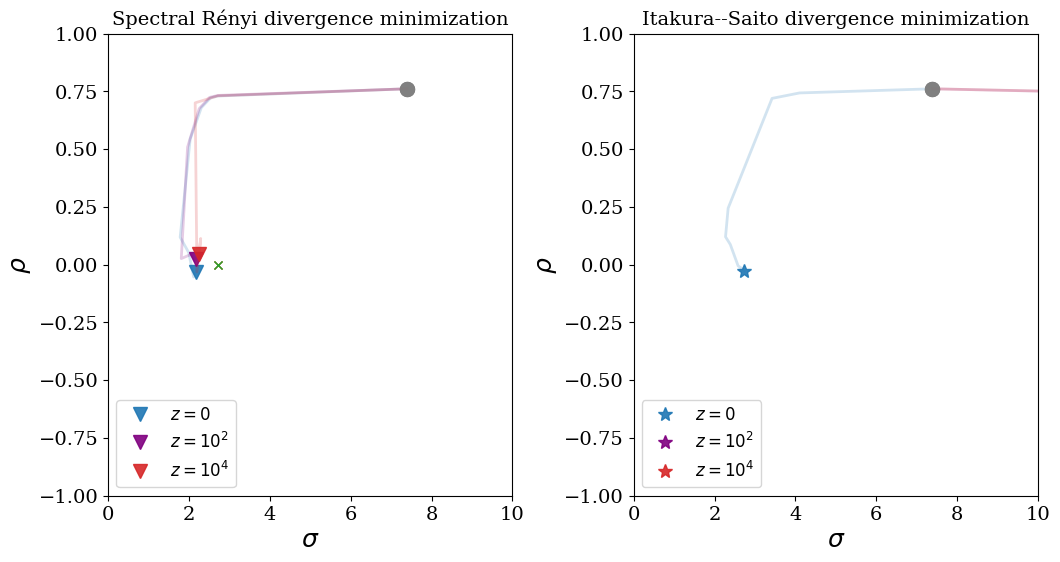

In [49]:
fontsize = 18
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
fig.subplots_adjust(wspace=0.3)

ax1.set_xlabel(r"$\sigma$",fontsize=fontsize)
ax1.set_ylabel(r"$\rho$",fontsize=fontsize)
ax2.set_xlabel(r"$\sigma$",fontsize=fontsize)
ax2.set_ylabel(r"$\rho$",fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(axis='both', which='minor', labelsize=8)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='minor', labelsize=8)
ax1.set_xlim(0,10)
ax1.set_ylim(-1,1)
ax2.set_xlim(0,10)
ax2.set_ylim(-1,1)
ax1.set_title("Spectral Rényi divergence minimization",fontsize=14)
ax2.set_title("Itakura--Saito divergence minimization",fontsize=14)
colors = ["tab:blue","purple","tab:red"]
z_list = [r"$0$",r"$10^{2}$",r"$10^{4}$"]
for i in range(3):
  ax1.plot(theta1_sigma(results[i][4][:,0]),theta2_rho(results[i][4][:,1]),"-",color=colors[i],alpha=0.2)
  ax1.plot(theta1_sigma(results[i][4][-1,0]),theta2_rho(results[i][4][-1,1]),"v",label=r"$z=$"+z_list[i],color=colors[i],alpha=0.9,markersize=10)
  ax1.plot(theta1_sigma(true[0]),theta2_rho(true[1]),"x")
  ax1.plot(theta1_sigma(results[0][0][0,0]),theta2_rho(results[0][0][0,1]),"o",color="gray",alpha=0.9,markersize=10)
  ax2.plot(theta1_sigma(results_IS[i][:,0]),theta2_rho(results_IS[i][:,1]),color=colors[i],alpha=0.2)
  ax2.plot(theta1_sigma(results_IS[0][0,0]),theta2_rho(results_IS[0][0,1]),"o",color="gray",alpha=0.9,markersize=10)
  ax2.plot(theta1_sigma(results_IS[i][-1,0]),theta2_rho(results_IS[i][-1,1]),"*",label=r"$z=$"+z_list[i],color=colors[i],alpha=0.9,markersize=10)
  ax1.legend(fontsize=fontsize-6)
  ax2.legend(fontsize=fontsize-6)